# Vehicle Type Classification with **XGBoost**

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load the dataset
file_path = "/Users/jakob/Library/CloudStorage/OneDrive-student.kit.edu/Studium/02_Master/4. Semester/seminar/RoadTrafficNoise/IDMT-Traffic/datasets/df_main_encoded_only.csv"

# Load the dataset
df_vehicle_classification = pd.read_csv(file_path)

print(df_vehicle_classification.head())

   Unnamed: 0                                               file  \
0          18  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
1          19  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1116695...   
2          20  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
3          21  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1137602...   
4          24  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1141442...   

   is_background_encoded  date_time_encoded  location_encoded  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   

   speed_kmh_encoded  daytime_encoded  weather_encoded  vehicle_encoded  \
0                  0                1                0                1   
1                  0                1             

All features used

In [ ]:
# Extract features and target
# Drop "vehicle_encoded" as it is the target feature. Drop 'file' as it contains all metadata and 'is_background_encoded' as it is unnecessary (always 0)
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded'])
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74        21
           1       0.92      0.98      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.71      0.36      0.47       205

    accuracy                           0.91      1873
   macro avg       0.86      0.75      0.79      1873
weighted avg       0.90      0.91      0.90      1873



In [13]:
# Extract feature importances from the trained XGBoost model
feature_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Print the sorted feature importances
print(sorted_importances)

date_time_encoded           0.346342
microphone_encoded          0.101849
location_encoded            0.053933
channel_encoded             0.037486
band_18_dB                  0.030475
band_19_dB                  0.027688
weather_encoded             0.015317
daytime_encoded             0.015200
speed_kmh_encoded           0.015175
mfcc_3                      0.014565
band_4_dB                   0.014536
band_3_dB                   0.013296
peak_freq_1                 0.012684
band_1_dB                   0.010888
source_direction_encoded    0.010257
mfcc_5                      0.010189
mfcc_9                      0.009954
band_17_dB                  0.009464
band_20_dB                  0.009459
band_25_dB                  0.009026
Unnamed: 0                  0.008626
octband_dB_mean             0.008384
band_2_dB                   0.008218
band_12_dB                  0.007728
band_27_dB                  0.007589
band_13_dB                  0.007556
peak_dB_2                   0.007320
b

We seems as if the feature date_time has a big influence on the classification. Maybe there is some data leakage. Let's do a plot to show the occurences of vehicle types at the 22 date_time entries:

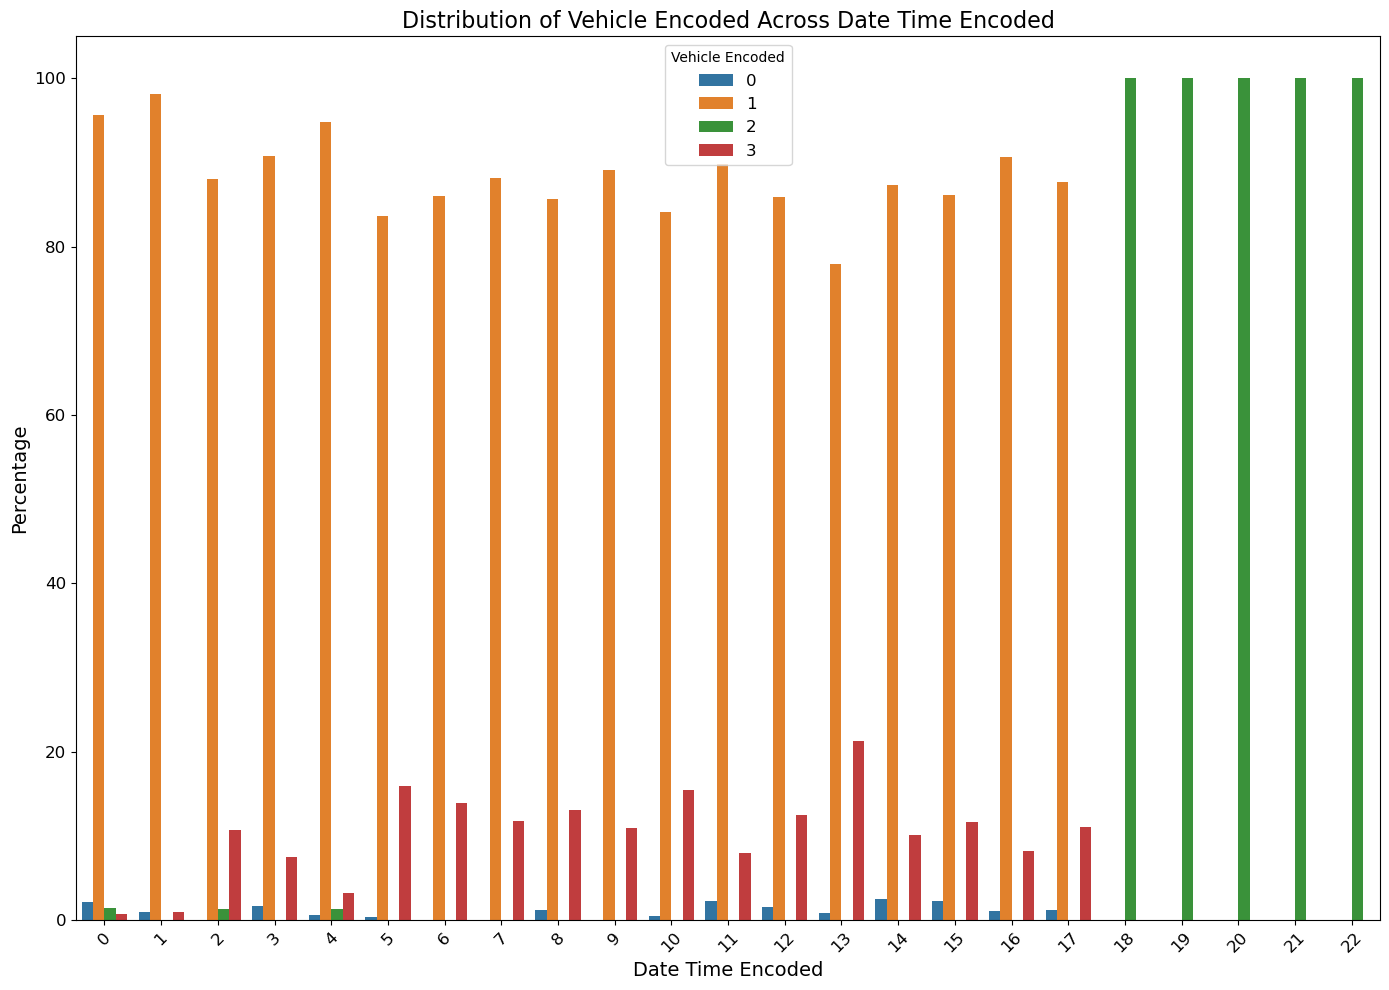

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by `date_time_encoded` and `vehicle_encoded` to count occurrences
grouped_data = df_vehicle_classification.groupby(['date_time_encoded', 'vehicle_encoded']).size().reset_index(name='count')

# Normalize the counts within each `date_time_encoded` to calculate percentages
grouped_data['percentage'] = grouped_data.groupby('date_time_encoded')['count'].transform(lambda x: x / x.sum() * 100)

# Plot the data
plt.figure(figsize=(14, 10))
sns.barplot(data=grouped_data, x='date_time_encoded', y='percentage', hue='vehicle_encoded', palette='tab10')

# Customize the plot
plt.title('Distribution of Vehicle Encoded Across Date Time Encoded', fontsize=16)
plt.xlabel('Date Time Encoded', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Vehicle Encoded', fontsize=12)
plt.xticks(fontsize=12, rotation=45)  # Rotate for readability
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
# Pivot table
# Group by `date_time_encoded` and `vehicle_encoded` to count occurrences
grouped_data = df_vehicle_classification.groupby(['date_time_encoded', 'vehicle_encoded']).size().reset_index(name='count')

# Normalize the counts within each `date_time_encoded` to calculate percentages
grouped_data['percentage'] = grouped_data.groupby('date_time_encoded')['count'].transform(lambda x: x / x.sum() * 100)

# Pivot table to present numerical relationships
pivot_table = grouped_data.pivot(index='date_time_encoded', columns='vehicle_encoded', values='percentage').fillna(0)

# Print the pivot table
print(pivot_table)

vehicle_encoded           0          1           2          3
date_time_encoded                                            
0                  2.189781  95.620438    1.459854   0.729927
1                  0.938967  98.122066    0.000000   0.938967
2                  0.000000  88.000000    1.333333  10.666667
3                  1.666667  90.833333    0.000000   7.500000
4                  0.653595  94.771242    1.307190   3.267974
5                  0.418410  83.682008    0.000000  15.899582
6                  0.000000  86.046512    0.000000  13.953488
7                  0.000000  88.211382    0.000000  11.788618
8                  1.158301  85.714286    0.000000  13.127413
9                  0.000000  89.108911    0.000000  10.891089
10                 0.475059  84.085511    0.000000  15.439430
11                 2.212389  89.823009    0.000000   7.964602
12                 1.591512  85.941645    0.000000  12.466844
13                 0.787402  77.952756    0.000000  21.259843
14      

For date_time 18-22 there is only vehicle type 2. Including date_time could lead to overfitting, we should perform cross validation to determine if we should drop date_time from the classification.

Speed_kmh is another feature, that has a weird distribution that could lead to overfitting:

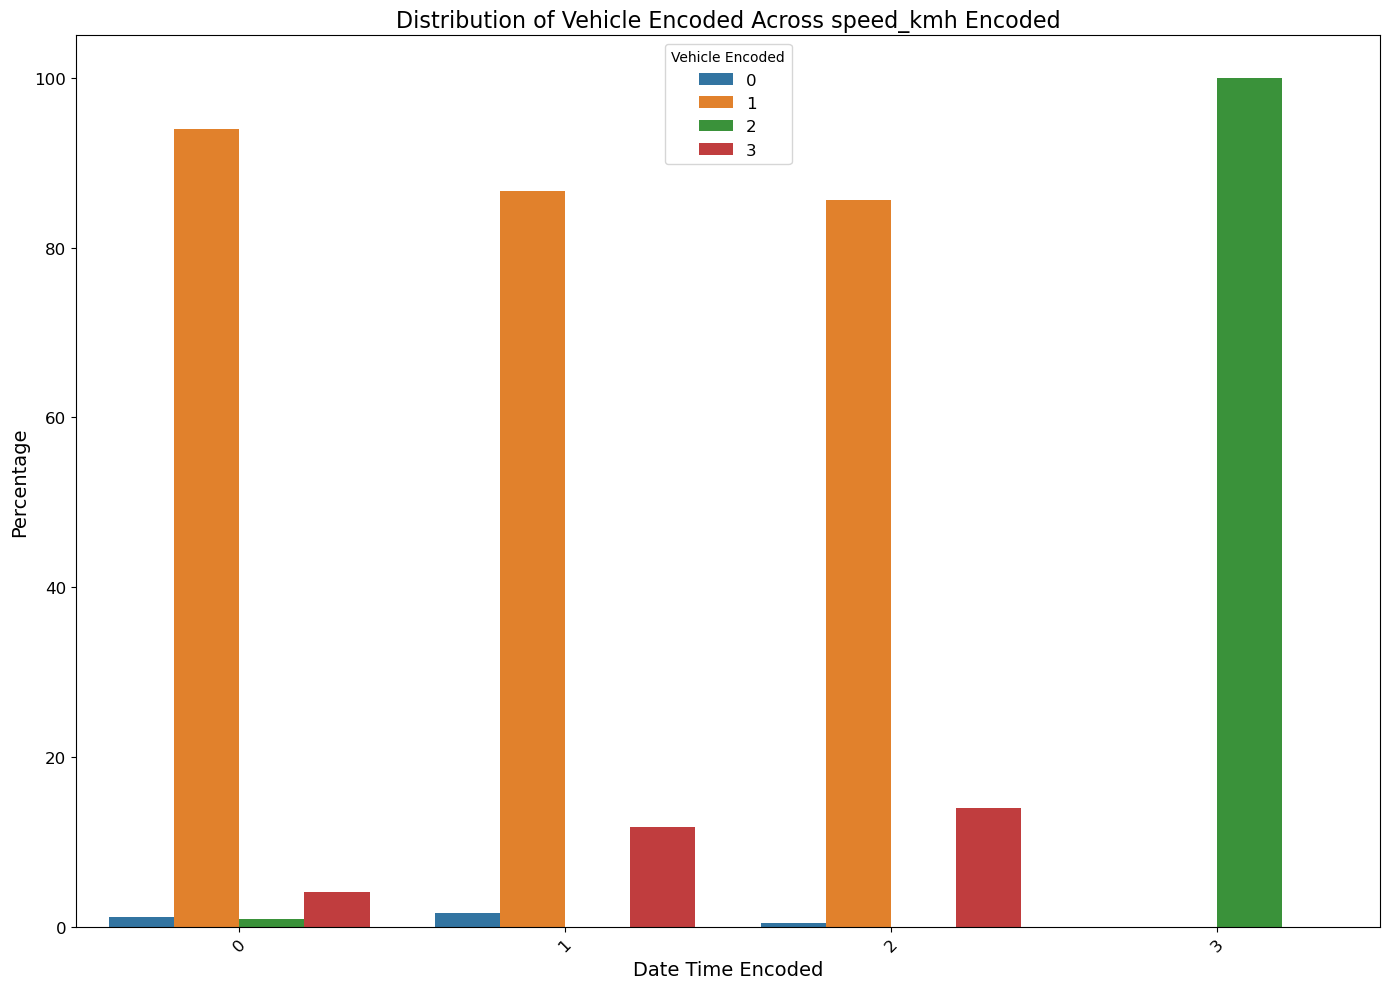

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by `speed_kmh_encoded` and `vehicle_encoded` to count occurrences
grouped_data = df_vehicle_classification.groupby(['speed_kmh_encoded', 'vehicle_encoded']).size().reset_index(name='count')

# Normalize the counts within each `speed_kmh_encoded` to calculate percentages
grouped_data['percentage'] = grouped_data.groupby('speed_kmh_encoded')['count'].transform(lambda x: x / x.sum() * 100)

# Plot the data
plt.figure(figsize=(14, 10))
sns.barplot(data=grouped_data, x='speed_kmh_encoded', y='percentage', hue='vehicle_encoded', palette='tab10')

# Customize the plot
plt.title('Distribution of Vehicle Encoded Across speed_kmh Encoded', fontsize=16)
plt.xlabel('Date Time Encoded', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Vehicle Encoded', fontsize=12)
plt.xticks(fontsize=12, rotation=45)  # Rotate for readability
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

This relationship is dataset-specific and not generalizable, so the model still could overfit to the training data. We can try to combat this by using L1-L2-regularization.

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded'])
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the parameter grid for L1 and L2 regularization
param_grid = {
    'alpha': [0, 0.1, 0.5, 1, 5],       # L1 regularization
    'lambda': [0.5, 1, 2, 5, 10]       # L2 regularization
}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Perform Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

# Train the final model with the best parameters
best_xgb_clf = grid_search.best_estimator_
best_xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_clf.predict(X_test)

# Evaluate the final model
print("\nClassification Report on the Test Set:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'alpha': 5, 'lambda': 0.5}
Best cross-validated accuracy: 0.9110576923076924

Classification Report on the Test Set:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72        21
           1       0.93      0.98      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.76      0.42      0.55       205

    accuracy                           0.92      1873
   macro avg       0.89      0.75      0.80      1873
weighted avg       0.91      0.92      0.91      1873



The regularization has not been particularly successful in this case:
1. It didn’t significantly improve the overall performance or generalization of the model.
2. It slightly worsened performance for the minority class 0 while providing only a small improvement for Class 3.

Next try: Don't include grid search for regularization, and instead focus on class imbalances using SMOTE:

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded'])
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.94      0.95      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.58      0.56      0.57       205

    accuracy                           0.90      1873
   macro avg       0.84      0.80      0.82      1873
weighted avg       0.90      0.90      0.90      1873



The SMOTE approach is successful in addressing class imbalance, particularly for Class 3, which sees significant recall improvement. The slight loss in precision and accuracy is acceptable given the tradeoff of better minority class coverage.

How does it look with class weights instead of using SMOTE?

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0', 'date_time_encoded'])
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Map weights to each sample in the training set
weights = y_train.map(class_weights)

# Initialize and train the XGBoost classifier with class weights
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.94      0.97      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.66      0.51      0.58       205

    accuracy                           0.92      1873
   macro avg       0.85      0.83      0.84      1873
weighted avg       0.91      0.92      0.91      1873



This was successful!
We should continue to use XGBoost with Class Weights instead of SMOTE, because it achieves the best balance between precision, recall, and F1-scores across all classes and the performance for minority classes (Class 0 and Class 3) improves without sacrificing accuracy or majority-class performance.

In [31]:
# Extract feature importances from the trained XGBoost model
feature_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Print the sorted feature importances
print(sorted_importances)

speed_kmh_encoded           0.488163
mfcc_3                      0.055492
band_2_dB                   0.045518
octband_dB_mean             0.042451
band_18_dB                  0.037202
location_encoded            0.024930
band_19_dB                  0.017806
weather_encoded             0.014397
mfcc_13                     0.012972
band_4_dB                   0.011977
peak_dB_3                   0.011482
mfcc_5                      0.011169
band_3_dB                   0.010419
mfcc_2                      0.010234
peak_freq_1                 0.008935
band_5_dB                   0.008933
band_23_dB                  0.008867
mfcc_8                      0.008673
band_20_dB                  0.008282
daytime_encoded             0.008082
band_27_dB                  0.008071
mfcc_9                      0.007810
peak_freq_2                 0.007671
source_direction_encoded    0.007190
band_12_dB                  0.007000
band_11_dB                  0.006763
band_28_dB                  0.005595
b

In [32]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0'])
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Map weights to each sample in the training set
weights = y_train.map(class_weights)

# Initialize and train the XGBoost classifier with class weights
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        21
           1       0.94      0.97      0.96      1561
           2       1.00      0.99      0.99        86
           3       0.70      0.54      0.61       205

    accuracy                           0.92      1873
   macro avg       0.87      0.85      0.85      1873
weighted avg       0.92      0.92      0.92      1873



with cross-validation:

In [36]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

# Extract features and target
X = df_vehicle_classification.drop(columns=['file', 'vehicle_encoded', 'is_background_encoded', 'Unnamed: 0'])
y = df_vehicle_classification['vehicle_encoded']

# Calculate class weights
class_counts = np.bincount(y)
total_samples = len(y)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)

# StratifiedKFold for consistent splits across classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(
    xgb_clf,
    X,
    y,
    cv=cv,
    scoring='f1_macro',
    fit_params={'sample_weight': y.map(class_weights)}  # Apply sample weights
)

# Print cross-validation results
print("Cross-Validation F1 Macro Scores:", scores)
print("Mean CV F1 Macro Score:", scores.mean())

# Final model training and testing on a single train-test split for reporting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
weights_train = y_train.map(class_weights)

# Train the model on the training set
xgb_clf.fit(X_train, y_train, sample_weight=weights_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

/Users/jakob/miniconda3/envs/seminar2024/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


Cross-Validation F1 Macro Scores: [0.82079032 0.8465162  0.83642624 0.82251722 0.80458688]
Mean CV F1 Macro Score: 0.8261673705810143

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.94      0.96      0.95      1561
           2       1.00      0.99      0.99        86
           3       0.66      0.53      0.59       205

    accuracy                           0.92      1873
   macro avg       0.87      0.85      0.86      1873
weighted avg       0.91      0.92      0.91      1873



Key Takeaways:
1. Stability Across Folds: 
    - The small variance in cross-validation F1 scores shows the model is robust and not overly sensitive to specific splits.
2.	Minority Class Performance: 
    - Significant improvement for Class 0, with F1: 0.88.
    - Class 3 remains the most challenging, with limited recall (0.53) due to imbalance and overlap with other classes.
3.	Strong Overall Balance:
    - Macro F1 scores during CV and testing show the model performs well across all classes without overly favoring the majority class.

The model shows no signs of overfitting due to date_time_encoded or speed_kmh_encoded, and their inclusion enhances performance for minority classes. The unusual distribution in specific time periods and specific speed_kmh levels does not unduly bias the model.

In the end the best performance for XGBoost Classification is being reached by 
- including all meta data features (except "file", "is_background", "Unnamed: 0" and "vehicle" obviously) as well as all audio features
- using class weights instead of SMOTE
- using cross-validation

### How do the results compare to only including sound features (MFCCs, Octavebands) for the classification?

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Extract features and target
X = df_vehicle_classification.drop(columns=df_vehicle_classification.loc[:, :'channel_encoded'].columns) # only keep sound features
y = df_vehicle_classification['vehicle_encoded']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate class weights
class_counts = np.bincount(y_train)
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Map weights to each sample in the training set
weights = y_train.map(class_weights)

# Initialize and train the XGBoost classifier with class weights
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))

Classification Report on test set:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.93      0.96      0.94      1561
           2       0.92      0.95      0.94        86
           3       0.62      0.45      0.52       205

    accuracy                           0.90      1873
   macro avg       0.83      0.79      0.81      1873
weighted avg       0.89      0.90      0.90      1873



Using only MFCC and octave bands results in slightly reduced performance overall, particularly for Class 3 (lower recall and F1).
- Macro-average F1 drops to 0.81, highlighting reduced balance across classes.
- MFCC and octave bands alone are insufficient compared to the richer feature set but perform reasonably well.